In [4]:
# Initialize empty lists for each column
psnr = []
ssim = []
rmse = []
pcc = []

# Read the metrics file
with open("Architecture/models/20250611_173045/metrics.txt", "r") as file:
    for line in file:
        # Skip comments and empty lines
        if line.startswith("#") or not line.strip():
            continue
        
        # Split the line into columns
        values = line.split()
        
        # Append values to respective lists
        psnr.append(float(values[0]))
        ssim.append(float(values[1]))
        rmse.append(float(values[2]))
        pcc.append(float(values[3]))

# Print the lists (optional)
print("PSNR:", psnr)
print("SSIM:", ssim)
print("RMSE:", rmse)
print("PCC:", pcc)

PSNR: [25.543834, 25.675447, 25.694265, 25.709074, 25.716811, 25.71571, 25.729219, 25.729242, 25.727841, 25.73783, 25.740016, 25.743072, 25.742748, 25.744842, 25.750209, 25.758608, 25.758226, 25.762773, 25.766862, 25.767048, 25.774271, 25.775596, 25.776561, 25.784416, 25.786565, 25.793651, 25.795149, 25.803496, 25.811146, 25.808877, 25.811923, 25.819253, 25.830237, 25.834156, 25.836912, 25.842998, 25.846635, 25.84419, 25.862326, 25.85769, 25.876035, 25.876095, 25.875186, 25.878223, 25.878488, 25.891875, 25.894421, 25.909131, 25.905158, 25.901437, 25.911595, 25.912877, 25.921868, 25.929233, 25.92857, 25.941461, 25.938876, 25.956924, 25.950641, 25.95705, 25.969158, 25.966925, 25.957583, 25.971325, 25.980424, 25.985668, 25.983801, 25.998579, 25.995775, 25.991959, 26.006235, 26.00798, 26.015664, 26.015896, 26.020427, 26.010745, 26.024019, 26.036453, 26.030491, 26.041889, 26.040343, 26.050861, 26.044361, 26.051446, 26.03949, 26.066313, 26.062292, 26.073658, 26.073911, 26.077952, 26.080611, 

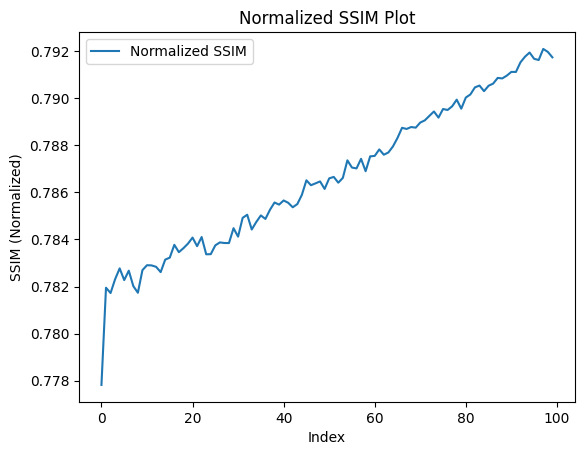

In [5]:
import matplotlib.pyplot as plt

# Normalize ssim to [0, 1]
normalized_ssim = [(x + 1) / 2 for x in ssim]

# Plot the normalized ssim
plt.plot(normalized_ssim, label="Normalized SSIM")
plt.xlabel("Index")
plt.ylabel("SSIM (Normalized)")
plt.title("Normalized SSIM Plot")
plt.legend()
plt.show()

Fitted params → L=1.0000, k=0.0047, x0=0.0


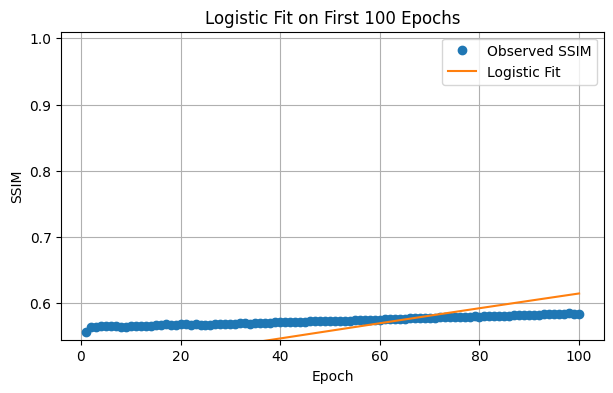

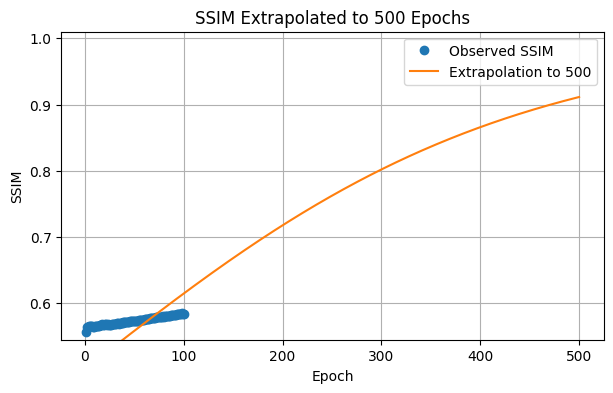

Predicted SSIM at 500 epochs: 0.9113


In [18]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# ─── your raw data ─────────────────────────────────────────────────────────────
# assume `ssim` is your Python list of SSIM values for epochs 1…N (e.g. N=100)
epochs = np.arange(1, len(ssim) + 1)
ssim_values = np.array(ssim)

# ─── logistic model ────────────────────────────────────────────────────────────
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# ─── dynamic bounds for L so p0 is always inside ───────────────────────────────
ssim_max = ssim_values.max()
eps = 1e-6
L_lower = min(ssim_max, 1.0 - eps)
if L_lower >= 1.0:
    L_lower = max(0.0, ssim_values.min() - eps)
bounds = (
    [L_lower, 0.001, 0.0],    # [L_min, k_min, x0_min]
    [1.0,     1.0,   len(epochs)*2]  # [L_max, k_max, x0_max]
)

# ─── initial guesses inside those bounds ───────────────────────────────────────
p0 = [
    ssim_max,           # L starts at observed max
    0.05,               # k = slow growth
    np.median(epochs)   # x0 ≈ halfway
]

# ─── fit to your first N epochs ────────────────────────────────────────────────
popt, _ = curve_fit(logistic, epochs, ssim_values, p0=p0, bounds=bounds, maxfev=10000)
L_fit, k_fit, x0_fit = popt
print(f"Fitted params → L={L_fit:.4f}, k={k_fit:.4f}, x0={x0_fit:.1f}")

# ─── plot fit on observed data ────────────────────────────────────────────────
plt.figure(figsize=(7,4))
plt.plot(epochs, ssim_values, 'o', label='Observed SSIM')
plt.plot(epochs, logistic(epochs, *popt), '-', label='Logistic Fit')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.ylim(ssim_values.min()*0.98, 1.01)
plt.title('Logistic Fit on First {} Epochs'.format(len(epochs)))
plt.legend()
plt.grid(True)
plt.show()

# ─── extrapolate to 500 epochs ────────────────────────────────────────────────
future_epochs = np.arange(1, 501)                 # change here: 1…500
predicted_ssim = logistic(future_epochs, *popt)

plt.figure(figsize=(7,4))
plt.plot(epochs, ssim_values, 'o', label='Observed SSIM')
plt.plot(future_epochs, predicted_ssim, '-', label='Extrapolation to 500')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.ylim(ssim_values.min()*0.98, 1.01)
plt.title('SSIM Extrapolated to 500 Epochs')
plt.legend()
plt.grid(True)
plt.show()

print(f"Predicted SSIM at 500 epochs: {predicted_ssim[-1]:.4f}")


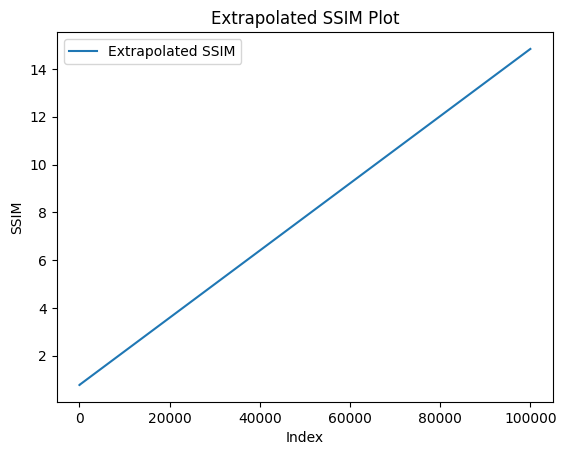

In [12]:
plt.plot(extrapolated_ssim, label="Extrapolated SSIM")
plt.xlabel("Index")
plt.ylabel("SSIM")
plt.title("Extrapolated SSIM Plot")
plt.legend()
plt.show()